# 7b Particles in a Proto-Planetary Disk

In this assigment you get, as a background for creating three experiments, three Python classes:  

1) A `Disk` class, which defines properties of a "standard accretion disk", such as Kepler rotation speed, surface density, disk scale height, and so on.  The gas in the disk is assumed to be moving inward, with a speed that conserves the radial flow of mass -- thus leaving the disk surface density constant in time.

2) A `Pressure_trap` class, which describes a simple, local pressure perturbation in a disk.  Such a perturbation can "trap" particles in a certain size range if the perturbation is strong enough to make the gas pressure increase outwards on the inside of the maximum.  When this is the case, the gas there has to rotate faster than the Kepler speed to stay in a nearly circular orbit.  

3) A `Particle` class, with a `KDK_drag()` particle motion integrator for particles moving in a disk with gas, influenced by forces of a) gravity and b) drag from moving through the gas.

Particles that are dragged along in this flow thus move faster than the Kepler speed, and experience an outward directed force.   If that force is larger than the inward drag from the accretion flow, the particle moves outwards, until it reaches a radius where the speed excess is just large enough to compensate for the inward drag from the accetion.

Particles outside the maximum, on the other hand, will move slower than they would in the unperturbed disk, and hence they will move even faster inwards

#### __Task 1: Particle motion in a standard disk__ (20 p)

Using the tools provided, set up an experiment with 15 particles, distributed evenly in a circle at radius 3, with 10-logarithm of the Stokes number __at radius=1__ equal to {-5, -4.5, ..., 2}.   Evolve them until the first particle reaches radius 0.3.   Discuss the result, in terms of the motion of "small", "intermediate" and "large" particles.

The Stokes number $\mathrm{St}$ is defined, for any one orbital radius, as the product of the angular velocity $\Omega=2\pi/t_{\mathrm{orbit}}$ and the stopping time $t_{\mathrm{s}}$, i.e. as

\begin{equation}\tag{1}
\mathrm{St} = \Omega t_{\mathrm{s}} = 2\pi \, t_{\mathrm{s}} / t_{\mathrm{orbit}}.
\end{equation}

The stopping time may be parameterized as

\begin{equation}\tag{2}
t_{\mathrm{s}}
= \frac{s}{\rho c_{\mathrm{drag}}},
\end{equation}

where $s$ is the size of the particle and $\rho$ is the gas density. The drag coefficient $c_{\mathrm{drag}}$ has dimensions of velocity over mass density and is assumed to be constant. In the Epstein regime it is equal to the thermal velocity divided by the solid density inside the dust particle: $c_{\mathrm{drag}} = v_\textrm{th} / \rho_\textrm{solid}$.

Use the definitions in the code to express the Stokes number $\mathrm{St}$ in terms of the code parameters. $\mathrm{St}=1$ when `s*2*pi/(drag*density)=1`.

#### __Task 2: Particle motion in a disk with a pressure trap__  (20 p)

Repeat the experiment, after adding a pressure trap at orbital radius $a=1$.   To choose the amplitude of the pressure trap it may be a good idea to plot the gas velocity as a function of radius in a loglog plot.   Note that you can actually estimate the size of particles that are not able to pass through the trap, since you can compute the largest speed excess, and from that you can estimate the outward force and balance it agains the drag from the inward motion of the gas. You need:

Discuss your results, and consider which particles can permeate the pressure trap barrier, and how does this critical dust size depend on the width of the pressure trap?

#### __Bonus Task for the curious: Evolve a large number of particles in the disk with a pressure trap__
Create particles distributed over size continuously, at radius $a=3$, and run for a long time (removing any particles that reach `rmin`), until you can see and discuss a clear trend.  The number of particle to launch per unit time will need to be a compromise: Too many and you cant' run them for very long, and too few = you won't have enough of them to make nice plots.   The results of Tasks 1 and 2, gives you a good background to figure out a good compromise.  Use the results from Task 2 to choose pressure trap parameters that trap some, but not all, particles.  Use trial-and-error (or measure the update speed) to fine tune the number of particles and the run time.

## The __Disk()__ Python class

The disk properties are defined as power laws with respect to radius; see for the class procedures below. Everything is normalized to unity at an orbital radius of 1, except a few parameters, which are given "realistic values". The first is related to the pressure profile: $\eta=0.002$. It determines the magnitude of the "head wind" through the relation
\begin{equation}
\eta = - {1 \over 2}\left(\frac{H}{r}\right)^2\,,
\end{equation}
where $H = c_s / \Omega$ is the disk scale height. $\eta$ describes how much slower the gas is orbiting in units of the Kepler speed $v_\textrm{gas} - v_K = \eta v_K (\partial\ln P / \partial\ln r)$. The second is the radial velocity of the gas $v_{rad}=0.0015$ at radius 1. An _acretion disk_ has accreting gas, and this is value corresponds to accretion in at a very high rate / very early in the evolution of the system. We can compute how much it is by inserting physical units

In [11]:
import numpy as np

sigma=1700.
kms=1e5
v_Kepler=30.*kms
vrad=0.0015
m_Sun=2e33
yr=3e7
AU=1.5e13
m_dot=sigma*v_Kepler*vrad*2.*np.pi*AU/(m_Sun/yr)
print('accretion rate = {:.1e} solar masses per year'.format(m_dot))

accretion rate = 1.1e-05 solar masses per year


In [12]:
def rp(r,p):
    """ Compute r**p, with special cases for common powers, to speed up computations
    """
    if p==-0.5:
        f=1.0/(np.sqrt(r))
    elif p==-1.0:
        f=1.0/r
    elif p==-1.5:
        f=1.0/(r*np.sqrt(r))
    elif p==-2.0:
        f=1.0/(r*r)
    elif p==-2.5:
        f=1.0/(r*r*np.sqrt(r))
    else:
        f=r**p
    return f

def magnitude(r):
    """ scalar magnitude of a vector """
    return np.sqrt(np.sum(r**2,0))

class Disk:
    """ Classical power law disk model, with optional pressure trap.
        
        We choose $G=(2\pi)^2$, such that the period at orbital radius 1 is one.
        We choose the common value -3/2 for the power index of the surface density,
        by default a temperature $\sim 1/r$.
    """
    def __init__(self, rmin=0.3, rmax=3, power=-1.5, power_T=-1.0, eta=0.002, drag=0.001, vrad=0.01, trap=None):
        self.G       = (2*np.pi)**2                     # for period=1 at orbital radius=1
        self.power   = power                            # surface density power index
        self.power_T = power_T                          # temperature power index
        self.power_d = power - 1.0 + (1.0+power_T)/2.0  # volume density power index
        self.power_P = self.power_d + power_T           # pressure = density * temperature
        self.eta     = eta                              # coefficient for head wind
        self.drag    = drag                             # coefficient for drag
        self.vrad    = vrad                             # coefficient for radial velocity
        self.rmin    = rmin                             # minimum radius
        self.rmax    = rmax                             # maximum radius
        self.trap    = trap                             # pressure trap

    def sigma(self,rm):
        """ Surface column density profile is rm^{power}
        """
        return rp(rm,self.power)

    def radial_speed (self,rm):
        """ The radial velocity is the one at 1 AU times rm^{power-1},
            since v_r 2 \pi r is the area per unit time covered.
        """
        return self.vrad*rp(rm,-self.power-1.0)

    def density(self,rm):
        """ Density profile.  If the temperature goes as 1/r, the sound speed and
            Kepler speed have the same scaling exponent and then the ratio of scale 
            height H to orbital radius a, H/a = c_sound/v_Kepler = constant, while 
            if the temperature is constant the disk "flares out" with a 1/2 extra
            power exponent
        """
        return rp(rm,self.power_d)

    def temperature(self,rm):
        """ Temperature profile
        """
        return rp(rm,self.power_T)

    def pressure(self,rm):
        """ Pressure profile
        """
        P = rp(rm,self.power_P)
        if self.trap is None:
            return P
        else:
            return P*self.trap.profile(rm,self.power)

    def dlnPdlnr(self,rm):
        """ dln(P)/dln(r); the logarithmic derivative of the pressure profile
        """
        if self.trap is None:
            return np.ones(len(rm))*self.power_P
        else:
            return self.power_P + self.trap.dlnPdlnr(rm)

    def Kepler_speed(self,rm):
        """ Kepler speed (scalar)
        """
        return np.sqrt(self.G/rm)
    
    def Omega(self,rm):
        """ Angular velocity """
        return 2.0*np.pi*rm(-0.5)
    
    def Kepler_velocity(self,r,rm):
        """ Three dimensional Kepler velocity
        """
        v = self.Kepler_speed(rm)
        rhat = r/rm
        return np.array([-rhat[1]*v,rhat[0]*v,np.zeros_like(rm)])

    def head_wind(self,rm):
        """ Head wind = the wind a particle gets "in the face" if moving with
            the Kepler speed -- positive when gas is slower than Kepler speed
        """
        return -self.Kepler_speed(rm)*self.eta*self.dlnPdlnr(rm)
    
    def gas_velocity(self,r):
        """ The gas velocity, including a week radial part, which is
            a constant fraction of the Kepler speed """
        rm = magnitude(r)
        vk = self.Kepler_speed(rm)          # scalar Kepler speed
        vg = vk - self.head_wind(rm)        # scalar azimuthal gas velocity
        vr = self.radial_speed(rm)          # scalar radial gas velocity
        rhat = r/rm                         # radial unit vector
        return np.array([-rhat[1]*vg - rhat[0]*vr, rhat[0]*vg - rhat[1]*vr, np.zeros_like(vg)])
    
    def drag_coeff(self,r,particle_size):
        rm = magnitude(r)
        return self.drag*self.density(rm)/particle_size

disk=Disk(drag=0)

### Power law scaling of various quantities

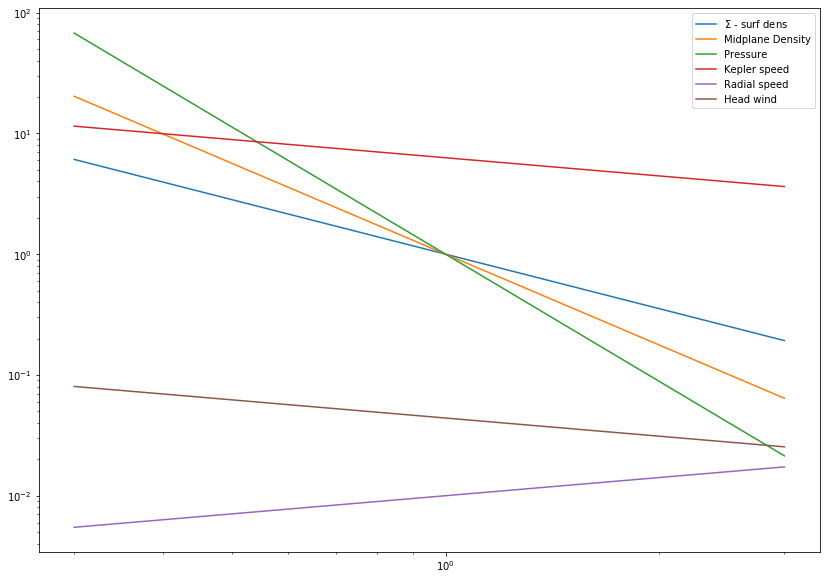

In [13]:
import matplotlib.pyplot as plt
from numpy import log10

disk = Disk()
a = np.logspace(log10(disk.rmin),log10(disk.rmax),100)
plt.figure(figsize=(14,10))
plt.loglog (a, disk.sigma(a),label='$\Sigma$ - surf dens')
plt.loglog (a, disk.density(a),label='Midplane Density')
plt.loglog (a, disk.pressure(a),label='Pressure')
plt.loglog (a, disk.Kepler_speed(a),label='Kepler speed')
plt.loglog (a, disk.radial_speed(a),label='Radial speed')
plt.loglog (a, disk.head_wind(a),label='Head wind')
plt.legend();

## The __Pressure_trap()__ Python class

A pressure trap has a profile with a local peak, and the derivative with respect to log radius adds to the d ln(P)/d ln(r) of the power law profile.   Here we use

\begin{equation}\tag{3}
  f(a) = \frac{d w^2+w^2+(a-r)^2}{w^2+(a-r)^2} \,,
\end{equation}

which has a peak value $d+1$, and a characteristic width $w$.

In [14]:
class Pressure_trap:
    def __init__(self,r=1.0,d=1.0,w=0.1):
        self.r = r
        self.d = d
        self.w = w
    def profile (self, r):
        """ Pressure trap profile, computed step-by-step to optimize speed
        """
        self.w2 = self.w**2
        self.dr = r-self.r
        self.A = self.d*self.w2
        self.B = self.w2 + self.dr**2
        self.C = self.A + self.B
        return self.C/self.B

    def dlnPdlnr(self,r):
        """ dln(P)/dln(r) of profile -- has common factors with profile
        """
        self.profile (r)
        return -(2.*self.A)*self.dr*r/(self.B*self.C)

#### Validate the expression for the derivative of the log profile with respect to log radius

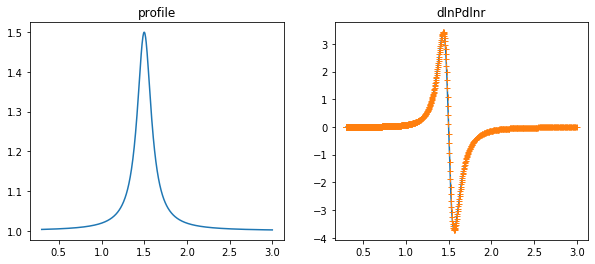

In [22]:
trap = Pressure_trap(r=1.5,w=.1,d=0.5)
r = np.logspace(log10(0.3),log10(3.),1000)
f = trap.profile(r)
D = np.gradient(np.log(f),np.log(r),edge_order=2)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(r,f); plt.title('profile')
plt.subplot(1,2,2); plt.plot(r,D); plt.title('dlnPdlnr')
plt.plot(r,trap.dlnPdlnr(r),'+');

## The __Particle()__ Python class

This includes as `KDK()` method (no gas), and a `KDK_drag()` method (with gas drag)v

#### Kick-Drift-Kick with drag

This is non-trivial in the case where the drag force dominates, so the drag equation is "stiff".   The solution is to use forward differencing in the drag equations (cf. Eqs 26-29 in [Popovas et al., MNRAS 2018](http://lanl.arxiv.org/abs/1801.07707)):

\begin{equation}\tag{4}
\def\v{{\bf v}}
\v(t + \Delta t/2) = \v(t) + \frac{C \Delta t}{1+C \Delta t} \left[\v_g - \v(t) \right]
\end{equation}

\begin{equation}\tag{5}
r_{new} = r(t + \Delta t) = r(t) + \Delta t\, \v(t + \Delta t/2) 
\end{equation}

\begin{equation}\tag{6}
t_{new} = t + \Delta t
\end{equation}

\begin{equation}\tag{7}
\v_{new}  = \v(t + \Delta) = \v(t+ \Delta t/2) + \frac{C \Delta t}{1+C \Delta t} \left[\v_g - \v(t) \right]
\end{equation}

From Eqs. (4) and (7) one can see that, in the limit when $C \rightarrow 0$, the procedure becomes the normal KDK.  In the limit when $C \rightarrow \infty$, the velocities go asymtotically towards the velocities of the gas.  Using that the coefficient $C$ is inversely proportional to particle size $s$, we thus see that the formalism ensures that small particles asymtotically follow the gas, as they indeed should.


In [16]:
from numpy import pi, exp, log, cos, sin, sqrt, random, zeros

class Particles:
    def __init__(self,n=10,nstep=100,rmin=0.3,rmax=3,disk=None,smin=1e-5,smax=1e2, St=None):
        self.n = n
        self.t = 0.0
        self.G = (2.*pi)**2
        self.nstep = nstep
        self.rmin = rmin
        self.rmax = rmax
        self.smin = smin
        self.smax = smax
#         if St!=None:
#             self.St=np.logspace(St[0],St[1],n, base=10)
#         else:
#             self.St=None
        self.initialize(St)
        self.disk = disk
#         if St!=None:
#             self.s = self.St/(2*np.pi)*self.disk.drag_coeff (self.r, self.s)*self.disk.density(self.r)

    def initialize(self, St):
        """ Initialize random particles uniformly in angle and a log radius interval,
            and with a uniform distribution of log particle size
        """
        self.rm = exp(log(self.rmin)+log(self.rmax/self.rmin)*random.random(self.n))
        angle = 2.0*pi*random.random(self.n)
        self.r = zeros((3,self.n))        
        self.r[0] = self.rm*cos(angle)
        self.r[1] = self.rm*sin(angle)
        v_Kepler = sqrt(self.G/magnitude(self.r))
        self.v = zeros((3,self.n))
        self.v[0] = -v_Kepler*sin(angle)
        self.v[1] = +v_Kepler*cos(angle)
        self.s = exp(log(self.smin)+log(self.smax/self.smin)*random.random(self.n))
        self.dt = zeros(self.n)
        
    def courant(self,same_dt=True):
        """ Determine time step(s) for at least self.nstep steps per orbit.
            If same_dt is True, take the same time step for all particles,
            If False, take nstep steps per orbit, for all radii
        """
        rm = magnitude(self.r)
        vm = magnitude(self.v)
        self.dt = (2.0*pi/self.nstep)*rm/vm
        if same_dt:
            self.dt[:] = self.dt.min()
            self.t = self.t + self.dt[0]

    def gravity(self):
        """ Compute the force of gravity
        """
        rm = magnitude(self.r)
        self.force = -self.r*self.G/(rm*rm*rm)
        return self.force

    def kick(self,step=0.5):
        """ Update the velocity with (default) half a time step.
        """
        self.gravity()
        self.v = self.v + step*self.dt*self.force

    def drift(self,step=1.0):
        """ Advance the positions one step
        """
        self.r = self.r + step*self.dt*self.v

    def KDK(self,same_dt=True):
        """ One Kick-Drift-Kick step 
        """
        self.courant(same_dt=same_dt)
        self.kick(0.5)
        self.drift(1.0)
        self.kick(0.5)

    def KDK_drag (self,same_dt=True):
        """ Kick-Drift-Kick step with gas drag, with a modified drift speed.
            The Cdt coefficient, which is proportional to the inverse stopping time,
            interpolates smoothly between (in the limit Cdt -> 0) the normal kick speed,
            and (in the limit Cdt -> infinity), the gas velocity.
        """
        self.courant(same_dt=same_dt)                               # time step at start
        self.kick(0.5)                                              # v_nogas at mid point
        r = self.r + 0.5*self.dt*self.v                             # mid point
        vg = self.disk.gas_velocity(r)                              # v_gas at mid point
        Cdt = self.disk.drag_coeff (r, self.s) * self.dt            # interpolation param
        self.v = self.v + (vg-self.v) * Cdt/(1.0+Cdt)               # mid point velocity
        self.drift(1.0)                                             # take a full step
        self.kick(0.5)                                              # v_nogas at end point
        vg = self.disk.gas_velocity(self.r)                         # v_gas at end point
        Cdt = self.disk.drag_coeff (self.r, self.s) * self.dt       # interpolation param
        self.v = self.v + (vg-self.v) * Cdt/(1.0+Cdt)               # end point velocity

    def show(self):
        """ Show the particle positions, projected onto the xy-plane
        """
        plt.figure(figsize=(7,7))
        plt.scatter(self.r[0],self.r[1],2.0);

### Orbit pieces for a given time interval (no gas drag)

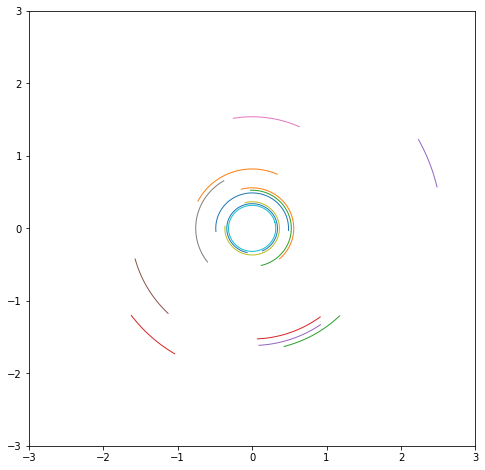

In [17]:
n=15
particles = Particles(n=n, St=(-5,2))
r = [particles.r]
for i in range(particles.nstep):
    particles.KDK(same_dt=True)
    r.append(particles.r)
r = np.array(r).transpose(2,1,0)     # (particle,coordinate,motion)
plt.figure(figsize=(8,8))
for i in range(r.shape[0]):
    plt.plot(r[i,0],r[i,1],linewidth=1)
rmax = particles.rmax; plt.xlim(-rmax,rmax); plt.ylim(-rmax,rmax);

### One orbit at all radii (no-gas)

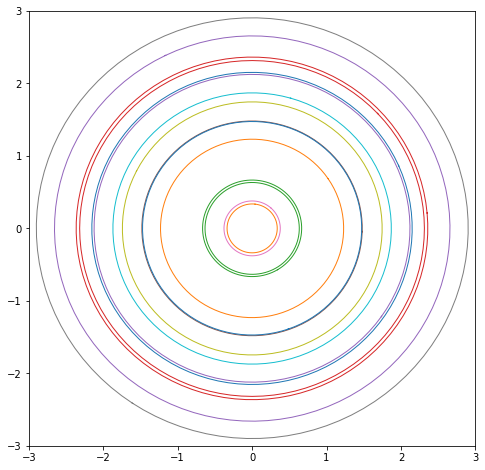

In [18]:
particles = Particles(n=15)
r = [particles.r]
for i in range(particles.nstep):
    particles.KDK(same_dt=False)
    r.append(particles.r)
r = np.array(r).transpose(2,1,0)     # (particle,coordinate,motion)
plt.figure(figsize=(8,8))
for i in range(r.shape[0]):
    plt.plot(r[i,0],r[i,1],linewidth=1)
rmax = particles.rmax; plt.xlim(-rmax,rmax); plt.ylim(-rmax,rmax);

### radial evolution for a set of particles

# __Absalon turn-in:__

Please answer the tasks, and add updated code below this line together with your discussion, and supporting plots. Upload as notebook and as pdf. _Hint_: it may be good approach to use (or get inspired by) the above examples, and wrap them in to a function or a class that allow you to easily setup, run, and plot interesting data for a given (size) distribution of particles.

# Task 1: 

See the change in the code below, and the verification that the quickest migration does indeed occur with Stokes number as close to 1 as possible

   0%
 7189


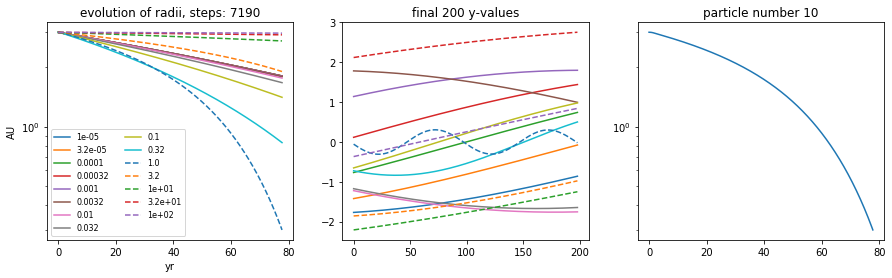

In [193]:
# Set up particles
Trap=None
drag=1.
itmax=1000

n=15
smin = 0.1
smax = 10.
rmax=3.
rmin=3.
nstep=100

disk=Disk(trap=Trap,drag=drag)
p=Particles(n=n,nstep=nstep,rmin=3,rmax=rmax,disk=disk,smin=smin,smax=smax)
phi=np.linspace(0.,2.*pi,p.n)
p.r[0]=p.rmax*cos(phi)
p.r[1]=p.rmax*sin(phi)
p.v=p.disk.Kepler_velocity(p.r,magnitude(p.r))
# p.s=np.logspace(np.log10(smin),np.log10(smax),p.n) #comment out if Stokes Number
St=np.logspace(-5,2, p.n)
p.s = St/(2*np.pi)*disk.drag # THIS IS THE CHANFE
# Evolve particles
rr=[p.r]
tt=[p.t]
it=0
output='{:5d}'
disk.rmin=0.3 # changed, remember to turn up itmax if needed
itmax=100000
while (magnitude(p.r).min() > disk.rmin and it < itmax):
    p.KDK_drag(same_dt=True)
    rr.append(p.r)
    tt.append(p.t)
    if it%(itmax//5)==0:
        print('{:4d}%'.format(it*100//itmax))
    it+=1
print(output.format(it))

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
rr=np.array(rr).transpose(2,1,0)        # (particle,component,path)
for i in range(rr.shape[0]):
    if i<=9:
        plt.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]))
    else:
        plt.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]), linestyle='dashed')
plt.legend(ncol=2, fontsize=8)
plt.xlabel('yr'); plt.ylabel('AU')
plt.title('evolution of radii, steps: {}'.format(rr.shape[2]));

plt.subplot(1,3,2)
nfinal=200
for i in range(rr.shape[0]):
    if i<=9:
        plt.plot(rr[i,1,-nfinal:-1])
    else:
        plt.plot(rr[i,1,-nfinal:-1], linestyle='dashed')
plt.title('final {} y-values'.format(nfinal));

plt.subplot(1,3,3)
rfin=rr[:,:,-1].transpose()
imin=magnitude(rfin).argmin()
plt.semilogy(tt,magnitude(rr[imin]))
plt.title('particle number {}'.format(imin));

Text(0.5, 1.0, 'Final radius as a function of St')

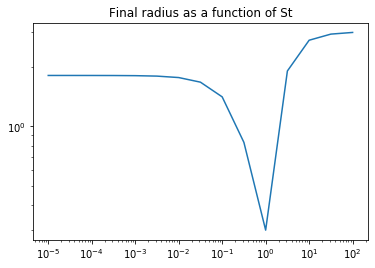

In [192]:
plt.loglog(St, magnitude(p.r))
plt.title('Final radius as a function of St')

One can also note that the smaller stokes number behave almost exactly the same, whereas things with St>>1 actually have the same profiles but are just much slower

# Problem 2 

# Making the trap

Repeat the experiment, after adding a pressure trap at orbital radius $a=1$.   To choose the amplitude of the pressure trap it may be a good idea to plot the gas velocity as a function of radius in a loglog plot.   Note that you can actually estimate the size of particles that are not able to pass through the trap, since you can compute the largest speed excess, and from that you can estimate the outward force and balance it agains the drag from the inward motion of the gas. You need:

I am guessing one could actually derive exactly what profile would work for different St, but I am going to mainly keep this in the coding regime

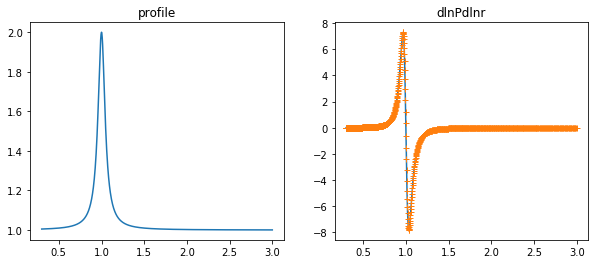

In [44]:
trap = Pressure_trap(r=1,w=.05,d=1)
r = np.logspace(log10(0.3),log10(3.),1000)
f = trap.profile(r)
D = np.gradient(np.log(f),np.log(r),edge_order=2)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(r,f); plt.title('profile')
plt.subplot(1,2,2); plt.plot(r,D); plt.title('dlnPdlnr')
plt.plot(r,trap.dlnPdlnr(r),'+');

Check the scenario where disk.rmin=0.3

   0%
  20%
  40%
  60%
  80%
100000


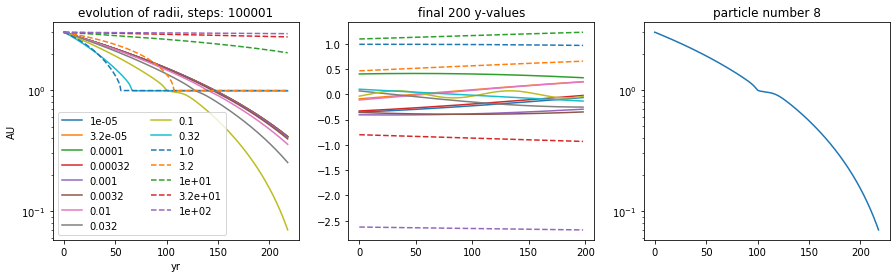

In [48]:
# Set up particles
Trap=Pressure_trap(r=1,w=.05,d=1.5)
drag=1.

n=15
smin = 0.1
smax = 10.
rmax=3.
rmin=3
nstep=100

disk=Disk(trap=Trap,drag=drag)
p=Particles(n=n,nstep=nstep,rmin=rmin,rmax=rmax,disk=disk,smin=smin,smax=smax)
phi=np.linspace(0.,2.*pi,p.n)
p.r[0]=p.rmax*cos(phi)
p.r[1]=p.rmax*sin(phi)
p.v=p.disk.Kepler_velocity(p.r,magnitude(p.r))
# p.s=np.logspace(np.log10(smin),np.log10(smax),p.n) #comment out if Stokes Number
St=np.logspace(-5,2, n) #remember to change the limits
p.s = St/(2*np.pi)*drag
# Evolve particles
rr=[p.r]
tt=[p.t]
vv=[disk.radial_speed(magnitude(p.r))]
it=0
output='{:5d}'
disk.rmin=0.3
itmax=100000
while (magnitude(p.r).min() > disk.rmin and it < itmax):
    p.KDK_drag(same_dt=True)
    rr.append(p.r)
    tt.append(p.t)
    vv.append(disk.radial_speed(magnitude(p.r)))
    if it%(itmax//5)==0:
        print('{:4d}%'.format(it*100//itmax))
    it+=1
print(output.format(it))

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
rr=np.array(rr).transpose(2,1,0)        # (particle,component,path)
for i in range(rr.shape[0]):
    if i<=9:
        plt.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]))
    else:
        plt.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]), linestyle='dashed')
plt.legend(ncol=2)
plt.xlabel('yr'); plt.ylabel('AU')
plt.title('evolution of radii, steps: {}'.format(rr.shape[2]));

plt.subplot(1,3,2)
nfinal=200
for i in range(rr.shape[0]):
    if i<=9:
        plt.plot(rr[i,1,-nfinal:-1])
    else:
        plt.plot(rr[i,1,-nfinal:-1], linestyle='dashed')
plt.title('final {} y-values'.format(nfinal));

plt.subplot(1,3,3)
rfin=rr[:,:,-1].transpose()
imin=magnitude(rfin).argmin()
plt.semilogy(tt,magnitude(rr[imin]))
plt.title('particle number {}'.format(imin));

Check the scenario where disk.rmin is very close to zero, so that we can get a better view of the full evolution. itmax has been turned up quite a lot for this so run this at your own risk.

   0%
  20%
  40%
  60%
610122


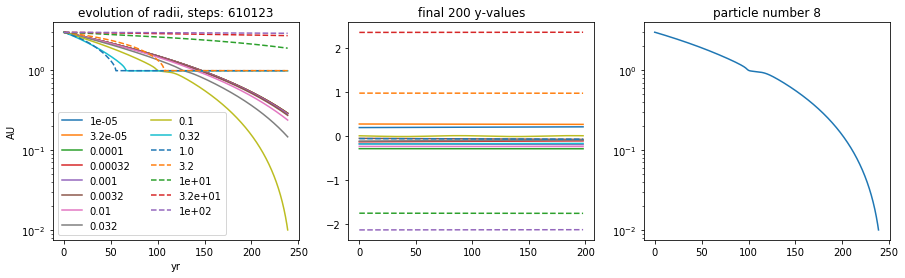

In [49]:
# Set up particles
Trap=Pressure_trap(r=1,w=.05,d=1.5)
drag=1.

n=15
smin = 0.1
smax = 10.
rmax=3.
rmin=3
nstep=100

disk=Disk(trap=Trap,drag=drag)
p=Particles(n=n,nstep=nstep,rmin=rmin,rmax=rmax,disk=disk,smin=smin,smax=smax)
phi=np.linspace(0.,2.*pi,p.n)
p.r[0]=p.rmax*cos(phi)
p.r[1]=p.rmax*sin(phi)
p.v=p.disk.Kepler_velocity(p.r,magnitude(p.r))
# p.s=np.logspace(np.log10(smin),np.log10(smax),p.n) #comment out if Stokes Number
St=np.logspace(-5,2, n) #remember to change the limits
p.s = St/(2*np.pi)*drag
# Evolve particles
rr=[p.r]
tt=[p.t]
vv=[disk.radial_speed(magnitude(p.r))]
it=0
output='{:5d}'
disk.rmin=0.01
itmax=1000000
while (magnitude(p.r).min() > disk.rmin and it < itmax):
    p.KDK_drag(same_dt=True)
    rr.append(p.r)
    tt.append(p.t)
    vv.append(disk.radial_speed(magnitude(p.r)))
    if it%(itmax//5)==0:
        print('{:4d}%'.format(it*100//itmax))
    it+=1
print(output.format(it))

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
rr=np.array(rr).transpose(2,1,0)        # (particle,component,path)
for i in range(rr.shape[0]):
    if i<=9:
        plt.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]))
    else:
        plt.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]), linestyle='dashed')
plt.legend(ncol=2)
plt.xlabel('yr'); plt.ylabel('AU')
plt.title('evolution of radii, steps: {}'.format(rr.shape[2]));

plt.subplot(1,3,2)
nfinal=200
for i in range(rr.shape[0]):
    if i<=9:
        plt.plot(rr[i,1,-nfinal:-1])
    else:
        plt.plot(rr[i,1,-nfinal:-1], linestyle='dashed')
plt.title('final {} y-values'.format(nfinal));

plt.subplot(1,3,3)
rfin=rr[:,:,-1].transpose()
imin=magnitude(rfin).argmin()
plt.semilogy(tt,magnitude(rr[imin]))
plt.title('particle number {}'.format(imin));

   0%
  20%
  40%
  60%
  80%
30000


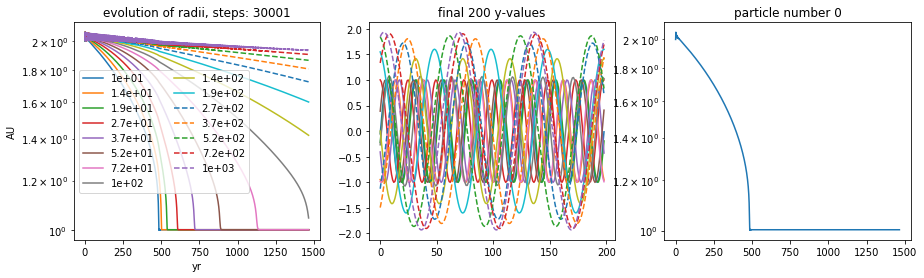

In [60]:
#Let's just do the big boys, once again this take a while so run at your own risk
Trap=Pressure_trap(r=1,w=.05,d=1.5)
drag=1.

n=15
smin = 0.1
smax = 10.
rmax=2.
rmin=2
nstep=25 #resolution down a bit

disk=Disk(trap=Trap,drag=drag)
p=Particles(n=n,nstep=nstep,rmin=rmin,rmax=rmax,disk=disk,smin=smin,smax=smax)
phi=np.linspace(0.,2.*pi,p.n)
p.r[0]=p.rmax*cos(phi)
p.r[1]=p.rmax*sin(phi)
p.v=p.disk.Kepler_velocity(p.r,magnitude(p.r))
# p.s=np.logspace(np.log10(smin),np.log10(smax),p.n) #comment out if Stokes Number
St=np.logspace(1,3, n) #remember to change the limits
p.s = St/(2*np.pi)*drag
# Evolve particles
rr=[p.r]
tt=[p.t]
vv=[disk.radial_speed(magnitude(p.r))]
it=0
output='{:5d}'
disk.rmin=0.01
itmax=30000
while (magnitude(p.r).min() > disk.rmin and it < itmax):
    p.KDK_drag(same_dt=True)
    rr.append(p.r)
    tt.append(p.t)
    vv.append(disk.radial_speed(magnitude(p.r)))
    if it%(itmax//5)==0:
        print('{:4d}%'.format(it*100//itmax))
    it+=1
print(output.format(it))

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
rr=np.array(rr).transpose(2,1,0)        # (particle,component,path)
for i in range(rr.shape[0]):
    if i<=9:
        plt.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]))
    else:
        plt.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]), linestyle='dashed')
plt.legend(ncol=2)
plt.xlabel('yr'); plt.ylabel('AU')
plt.title('evolution of radii, steps: {}'.format(rr.shape[2]));

plt.subplot(1,3,2)
nfinal=200
for i in range(rr.shape[0]):
    if i<=9:
        plt.plot(rr[i,1,-nfinal:-1])
    else:
        plt.plot(rr[i,1,-nfinal:-1], linestyle='dashed')
plt.title('final {} y-values'.format(nfinal));

plt.subplot(1,3,3)
rfin=rr[:,:,-1].transpose()
imin=magnitude(rfin).argmin()
plt.semilogy(tt,magnitude(rr[imin]))
plt.title('particle number {}'.format(imin));

So here we see that even things with very high Stokes Number gets stuck in the pressure trap. The smaller the Stokes Number, the more readily one passes through the pressure trap. Now let's see how this depends on the characteristics of the trap itself.

In [188]:
def trap_experiment(r=1,w=0.05,d=1.5, r0=3, lim=0.3, stlow=-2, stup=2, Plot=1):
    # Set up particles
    Trap=Pressure_trap(r=r,w=w,d=d)
    itmax=1000000
    n=15
    rmax, rmin=r0,r0
    nstep=100

    disk=Disk(trap=Trap,drag=1)
    disk.rmin=lim
    p=Particles(n=n,nstep=nstep,rmin=rmin,rmax=rmax,disk=disk,smin=smin,smax=smax)
    phi=np.linspace(0.,2.*pi,p.n)
    p.r[0]=p.rmax*cos(phi)
    p.r[1]=p.rmax*sin(phi)
    p.v=p.disk.Kepler_velocity(p.r,magnitude(p.r))
    St=np.logspace(stlow,stup, n) #remember to change the limits
    p.s = St/(2*np.pi)*drag
    # Evolve particles
    r=[magnitude(p.r)]
    rr=[p.r]
    tt=[p.t]
    vv=[disk.radial_speed(magnitude(p.r))]
    it=0
    output='{:5d}'
    while (magnitude(p.r).min() > disk.rmin and it < itmax):
        p.KDK_drag(same_dt=True)
        rr.append(p.r)
        tt.append(p.t)
        vv.append(disk.radial_speed(magnitude(p.r)))
        if it%(itmax//5)==0:
            print('{:4d}%'.format(it*100//itmax))
        it+=1
    print(output.format(it))
    r=[]
    rr=np.array(rr).transpose(2,1,0)
    for i in range(rr.shape[0]):
        r.append(magnitude(rr[i]))
    
    if Plot:
        fig, ax = plt.subplots(figsize=(12,9))
        for i in range(rr.shape[0]):
            if i<=9:
                ax.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]))
            else:
                ax.semilogy(tt,magnitude(rr[i]),label='{:.2}'.format(St[i]), linestyle='dashed')
        ax.legend(ncol=2)
        ax.set_xlabel('yr'); plt.ylabel('AU')
        ax.set_title('evolution of radii, steps: {}, width: {}, Amplitude: {}'.format(rr.shape[2], w, d));
    return r, tt

   0%
12821
   0%
 7787
   0%
 7499
   0%
 7333
   0%
 7230


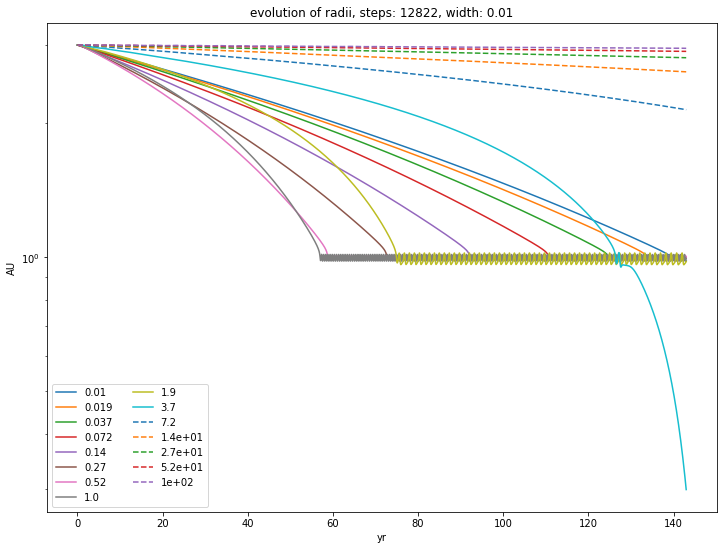

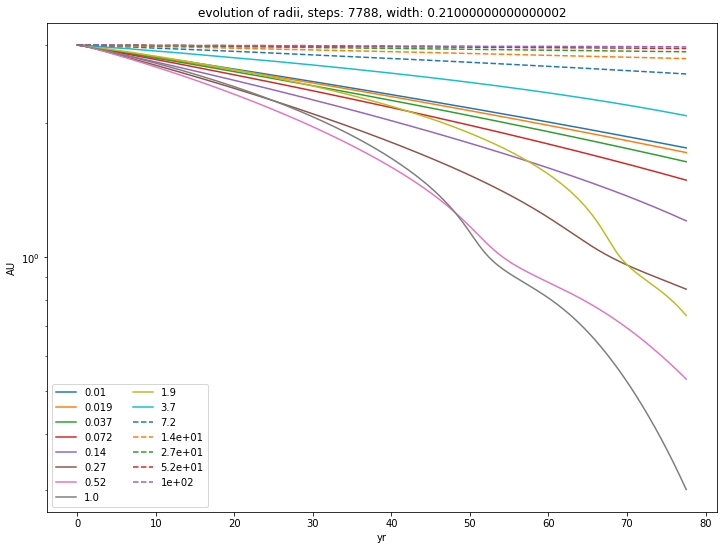

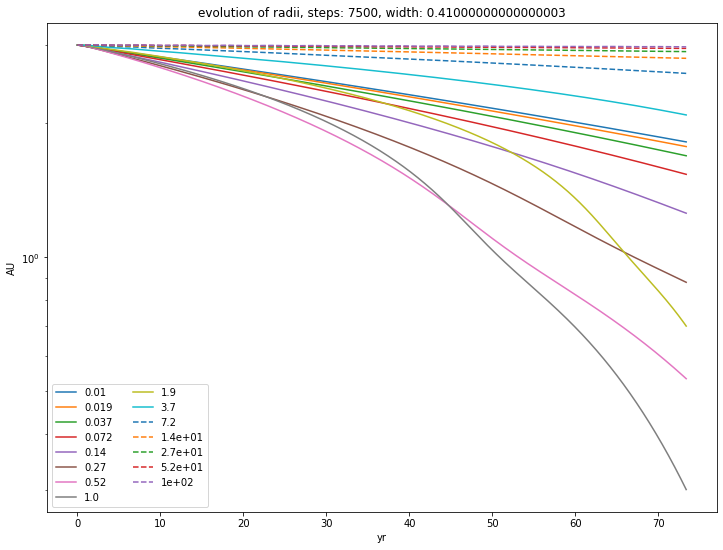

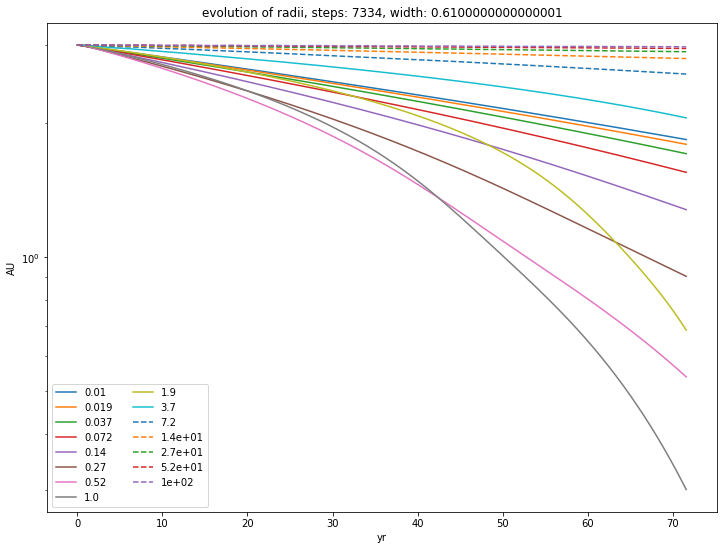

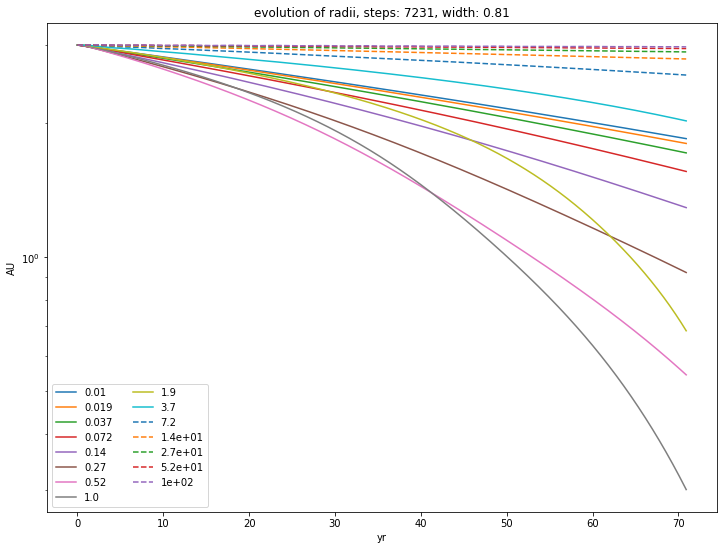

In [183]:
#let's investigate how the width changes things
r, t, s=[], [], []
ws=np.arange(0.01,1,0.2)
# ws=[0.05]
stlow, stup=-2,2
for w in ws:
    rr, tt=trap_experiment(w=w, stlow=stlow, stup=stup, Plot=1)
    rr, tt=np.array(rr), np.array(tt)
#     rr=np.sqrt(np.sum(np.array(rr)**2,1))
    r.append(rr)
    t.append(tt)
    s.append(np.sum(np.isclose(rr-1,0,atol=0.1), axis=1))

So we see that the width changes things drastically, which makes sense since the change is based in dlnP/dlnr, so a less steep profile would mean that the trap isn't as effective. Let's take another look at this first, in the domain of small d, and then at how the amplitude affects it.

   0%
31899
   0%
26806
   0%
22389
   0%
17348


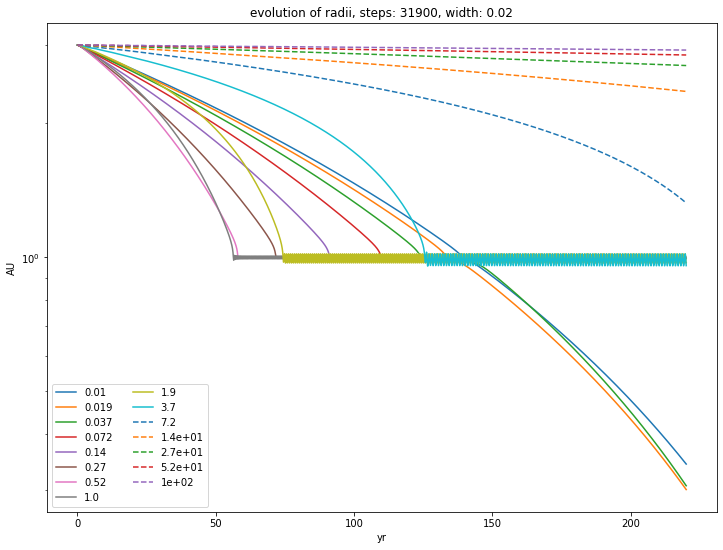

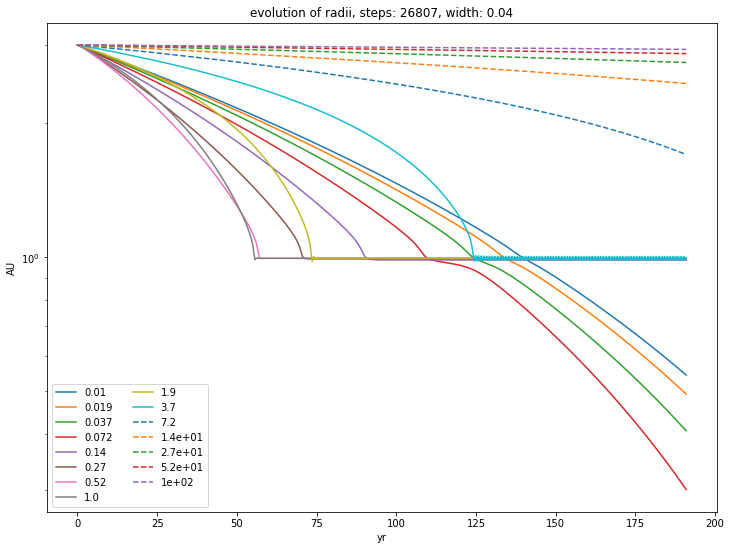

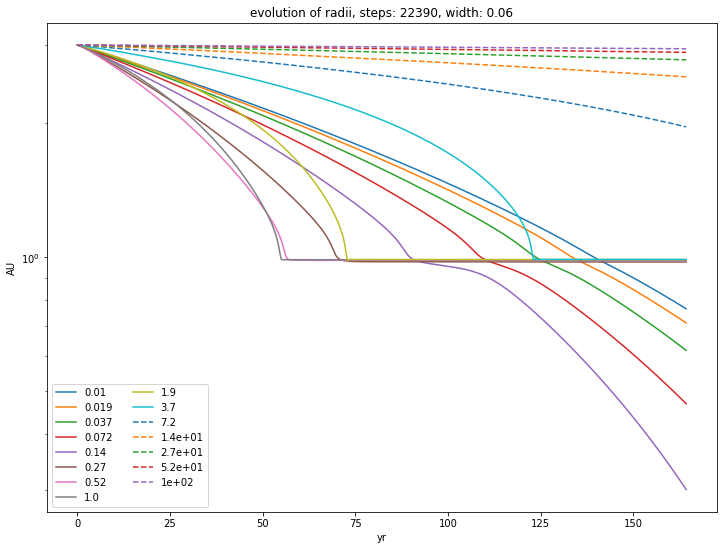

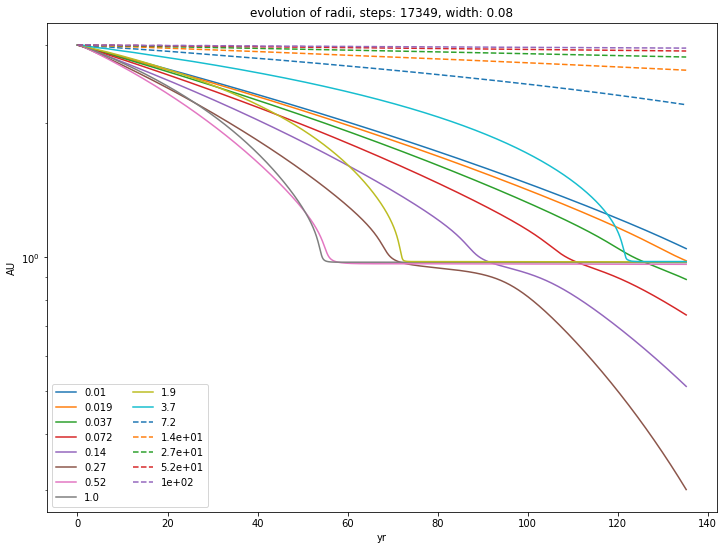

In [185]:
#let's investigate how the width changes things
r, t, s=[], [], []
ws=np.arange(0.02,0.1,0.02)
# ws=[0.05]
stlow, stup=-2,2
for w in ws:
    rr, tt=trap_experiment(w=w, stlow=stlow, stup=stup, Plot=1)
    rr, tt=np.array(rr), np.array(tt)
#     rr=np.sqrt(np.sum(np.array(rr)**2,1))
    r.append(rr)
    t.append(tt)
    s.append(np.sum(np.isclose(rr-1,0,atol=0.1), axis=1))

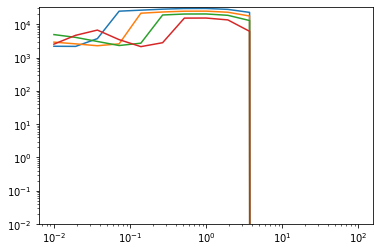

In [186]:
St=np.logspace(stlow, stup, 15)
for i in range(len(s)):
    plt.loglog(St, s[i])
    plt.ylim(1e-2,None)

So we see that, again, it's almost like the particles of Stokes number close to 1 or above hit a wall. We see that it's all the particles around St=1 that get stuck the quickest.

Let's see how the amplitude affects things.

   0%
21864
   0%
31165
   0%
33443
   0%
33713
   0%
33680


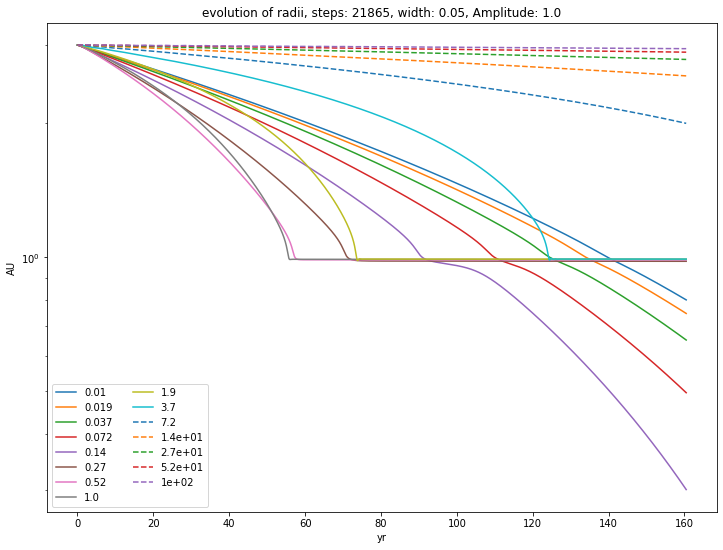

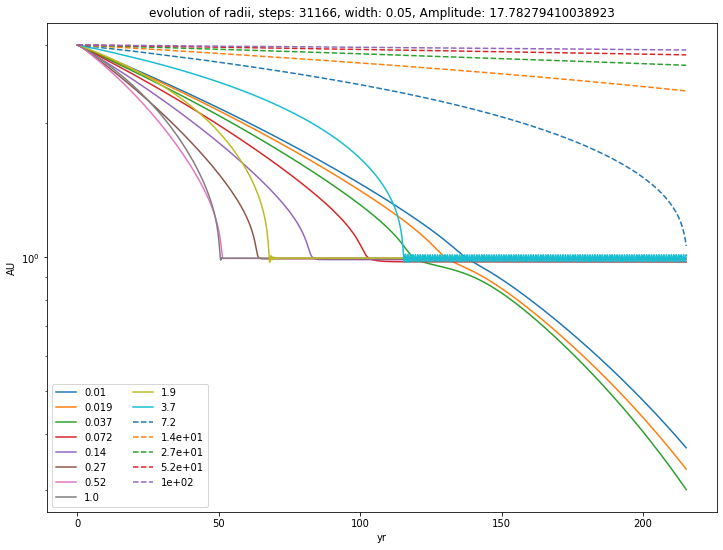

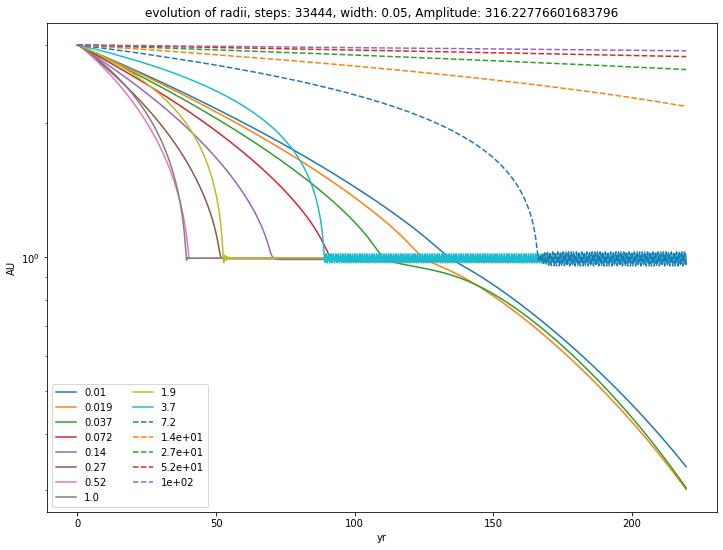

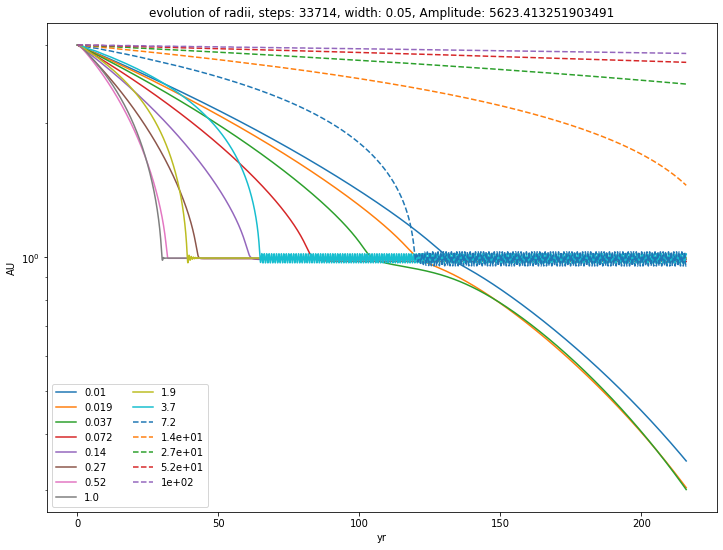

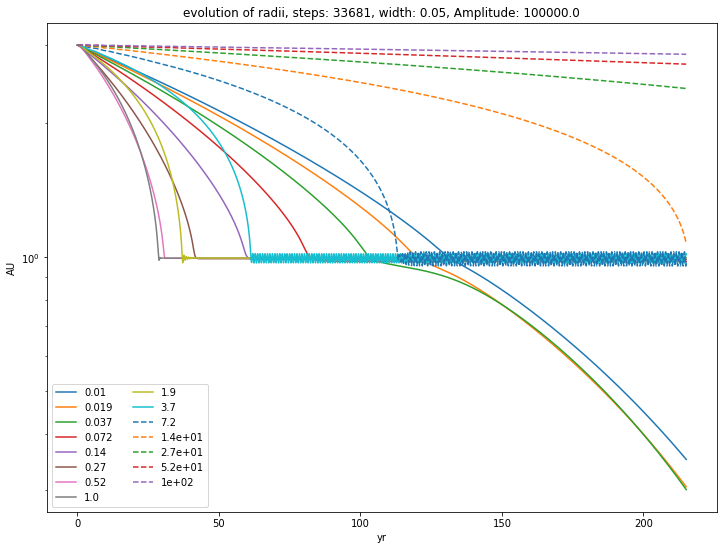

In [189]:
#let's investigate how the width changes things
r, t, s=[], [], []
stlow, stup=-2,2
ds=np.logspace(0,5,5)
for d in ds:
    rr, tt=trap_experiment(d=d, w=0.05, stlow=stlow, stup=stup, Plot=1)
    rr, tt=np.array(rr), np.array(tt)
#     rr=np.sqrt(np.sum(np.array(rr)**2,1))
    r.append(rr)
    t.append(tt)
    s.append(np.sum(np.isclose(rr-1,0,atol=0.1), axis=1))

All in all we see that the only things that can migarte inwards of the pressure trap are things with stokes number much less than one. Furthermore, the steeper the slope (less width higher amplitude), the harder the things that get caught get stuck, and the more the things that pass are affected as can be seen in the above plots.